# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на новые тарифы  «Смарт» или «Ультра». Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится.

*Примечание: значение accuracy должно превышать 0.75.*

Описание данных:   
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:   
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

## Знакомство с данными

In [1]:
%%capture
!pip install scikit-plot

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings

from joblib import dump

import scikitplot as skplt

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

In [ ]:
data = pd.read_csv('/datasets/users_behavior.csv')

data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [ ]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [ ]:
data.isna().sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

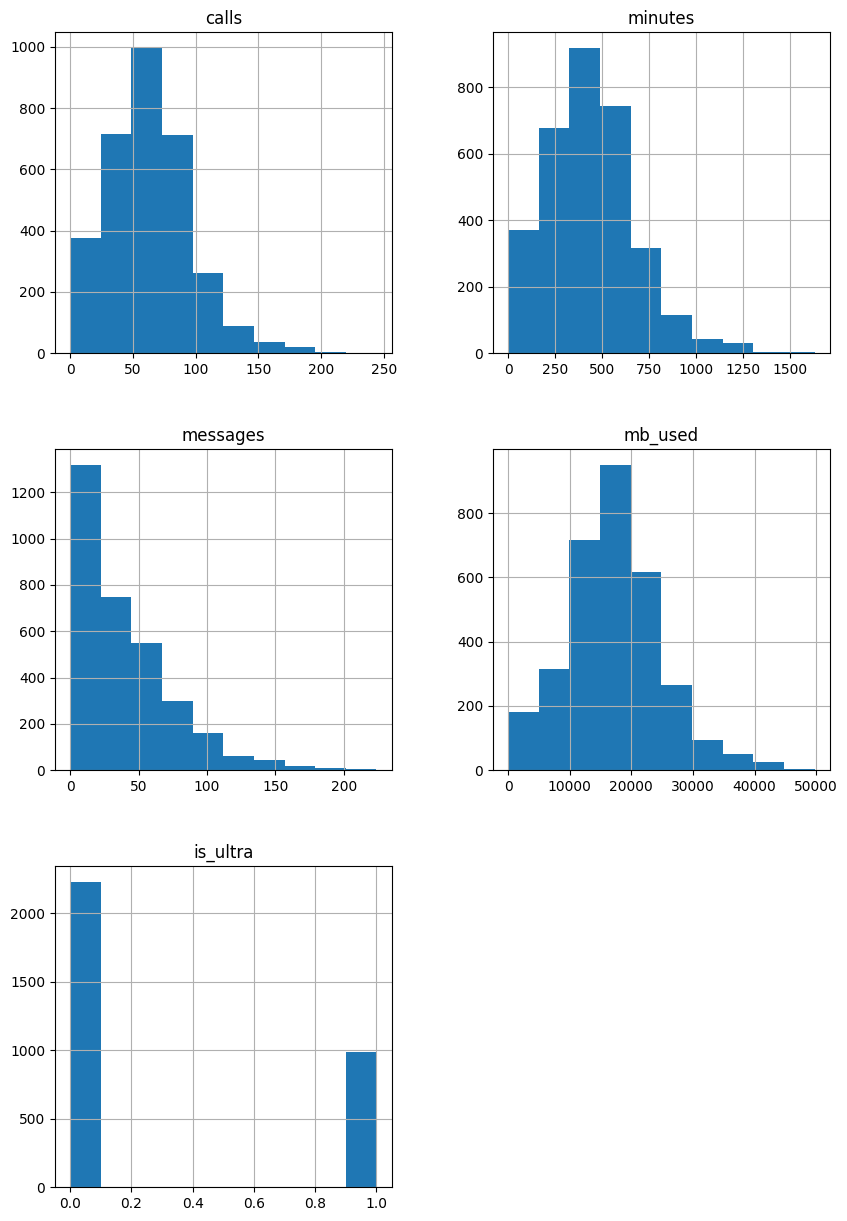

In [ ]:
data.hist(figsize=(10, 15));

Определим, имеется ли мультиколлинеарность, т.е. наличие корреляционной взаимосвязи между анализируемыми факторами, которые одновременно оказывают влияние на конечный результат, что может привести к возниконовению проблем с оценкой параметров.

In [ ]:
data.iloc[:,0:6].corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Высокая корреляция наблюдается между параметрами calls и minutes (0.98). Удалим столбец calls из датасета.

In [ ]:
data = data.drop(['calls'], axis=1)
data.head()

,minutes,messages,mb_used,is_ultra
0,311.90,83.0,19915.42,0
1,516.75,56.0,22696.96,0
2,467.66,86.0,21060.45,0
3,745.53,81.0,8437.39,1
4,418.74,1.0,14502.75,0


Посмотрим на соотношение классов.

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64


<Axes: >

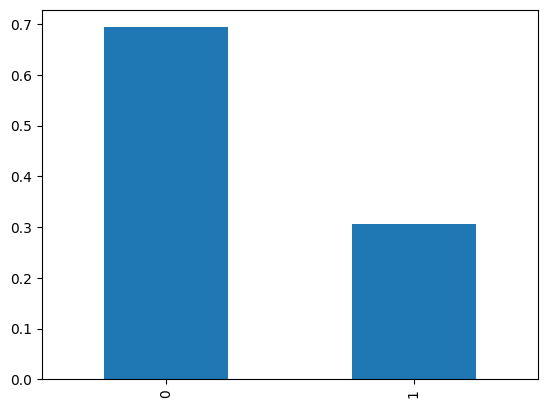

In [ ]:
class_frequency = data['is_ultra'].value_counts(normalize = 1)
print(class_frequency)
class_frequency.plot(kind='bar')

Наблюдается дисбаланс классов, поэтому при обучении моделей воспользуемся параметром class_weight.

**Вывод**      
Датасет содержит информацию о 3214 пользователях.   
Была выявлена высокая корреляция между параметрами calls и minutes (0.982083). Столбец calls был удален из датасета с целью устранения возможности влияния этой зависимости на конечный результат.     
Также был обнаружен дисбаланс классов.

## Разбиение данных на выборки

Разобъем данные на обучающую и тестовую выборки. Поскольку для подбора оптимальных гиперпараметров мы будем использовать кросс-валидацию, валидационная выборка нам не понадобится.

In [ ]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,
                                                                            random_state=12345, stratify=target)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape)

(2410, 3) (804, 3) (2410,) (804,)


## Исследование моделей

Построим модель логистической регрессии (Logistic Regression).

In [ ]:
lr = LogisticRegression(random_state=12345, class_weight='balanced')

param_grid = {'C': [1e-5, 1e5],
              'penalty': ['l1', 'l2']}
model_lr = GridSearchCV(lr, param_grid=param_grid, cv=5,
                  scoring={'Accuracy': 'accuracy'}, refit='Accuracy')
model_lr.fit(features_train, target_train)
print("Accuracy:", model_lr.best_score_)

Accuracy: 0.5186721991701244


Построим модель дерева принятия решений (Decision Tree).

In [ ]:
classifier_dt = DecisionTreeClassifier(random_state=12345, class_weight='balanced')

param_grid = {'max_depth': [depth for depth in range(1, 10)],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}
model_dt = RandomizedSearchCV(classifier_dt, param_distributions=param_grid, cv=5,
                   scoring={'Accuracy': 'accuracy'}, refit='Accuracy')

model_dt.fit(features_train, target_train)
print("Accuracy:", model_dt.best_score_)

Accuracy: 0.7763485477178422


Построим модель «случайный лес» (Random Forest).

In [ ]:
classifier_rf = RandomForestClassifier(random_state=12345, class_weight='balanced')

parameters = {'n_estimators': [est for est in range(1, 10)],
           'max_depth': [depth for depth in range(1, 10)],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4]}
model_rf = RandomizedSearchCV(classifier_rf, param_distributions=parameters, cv=5,
                              scoring={'Accuracy': 'accuracy'}, refit='Accuracy')
model_rf.fit(features_train, target_train)
print("Accuracy:", model_rf.best_score_)

Accuracy: 0.7887966804979254


Таким образом, лучший результат показала модель случайного леса. Она и будет использоваться для проверки на тестовой выборке.

In [ ]:
best_model = model_rf.best_estimator_

Построим кривую обучения для визуальной оценки процесса обучения модели Random Forest.

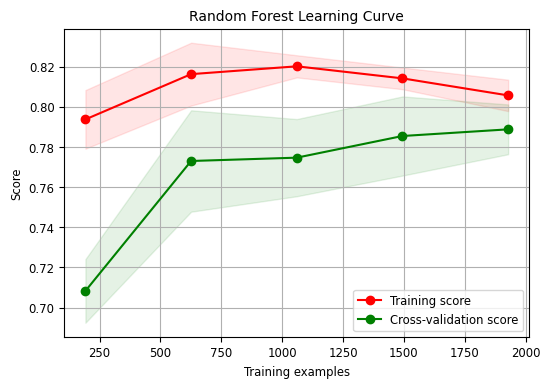

In [ ]:
skplt.estimators.plot_learning_curve(best_model, features_train, target_train,
                                     figsize=(6,4), title_fontsize="medium", text_fontsize="small",
                                     title="Random Forest Learning Curve");

Кривая обучения модели и на обучающем, и на проверочном наборе данных сходится и стабилизируется на достаточно высоком уровне точности. Это может указывать на то, что модель хорошо обобщает данные и не переобучена.

## Проверка модели на тестовой выборке

Проверим модель на тестовой выборке, применив метод RandomForestClassifier с установленными оптимальными гиперпараметрами.

In [ ]:
predictions_test = best_model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_test)
print("Accuracy модели на тестовой выборке:", accuracy)

Accuracy модели на тестовой выборке: 0.8159203980099502


Модель прошла проверку.   
Построим матрицу ошибок выбранной нами модели.   

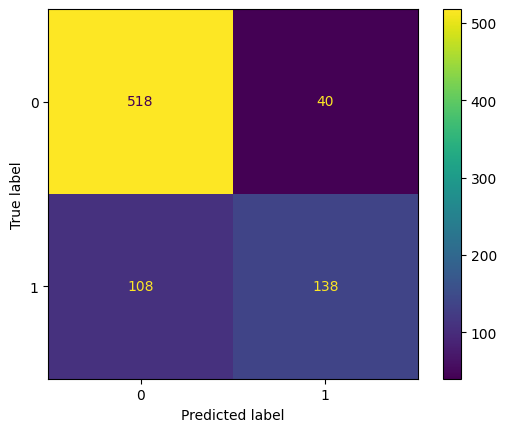

In [ ]:
cm = confusion_matrix(target_test, predictions_test, labels=model_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model_rf.classes_)
disp.plot()
plt.show()

Матрица ошибок показала достаточно высокую производительность модели.

## Проверка модели на адекватность

Проверим модель на адекватность при помощи dummy-классификатора. Использование этой baseline модели поможет проконтролировать, дала ли наша более сложная модель прирост качества.

In [ ]:
dc_model = DummyClassifier(strategy="most_frequent")
dc_model.fit(features_train, target_train)
predictions_dc_model = dc_model.predict(features_test)
accuracy = accuracy_score(target_test, predictions_dc_model)
print("Accuracy модели:", accuracy)

Accuracy модели: 0.6940298507462687


Accuracy dummy модели значительно ниже обученной нами модели.

## Вывод

Была выявлена высокая корреляция между параметрами calls и minutes. Столбец calls был удален из датасета с целью устранения возможности влияния этой зависимости на конечный результат.
Также был обнаружен дисбаланс классов. Для его устранения был использован параметр class_weight.          
Были обучены модели дерева принятия решений (Decision Tree), случайный лес (Random Forest) и модель логистической регрессии (Logistic Regression).       
Поскольку модель случайного леса показала лучший результат, она и была использована для проверки на тестовой выборке. Модель прошла проверку, так как accuracy превысило значение 0.75.       
Модель также была проверена на адекватность при помощи dummy-классификатора. Использование этой baseline модели помогло проконтролировать, что Random Forest дал прирост качества.     
Матрица ошибок (confusion matrix) также показала достаточно высокую производительность модели.